## Table of Contents
* [Introduction](#Introduction)
* [Common Model Inputs](#Common-Model-Inputs)
    * [Model-Independent Inputs](#Model-Independent-Inputs)
        * [Storage Object](#Storage-Object)
        * [Forward Curve](#Forward-Curve)
        * [Interest Rates Curve](#Interest-Rates-Curve)
        * [Settlement Rule](#Settlement-Rule)
        * [Valuation Date, Inventory and Discount Deltas](#Valuation-Date,-Inventory-and-Discount-Deltas)
    * [Least Square Monte Carlo Common Inputs](#Least-Square-Monte-Carlo-Common-Inputs)
* [Three-Factor Seasonal Model](#Three-Factor-Seasonal-Model)
    * [Three-Factor Seasonal Model Specific Inputs](#Three-Factor-Seasonal-Model-Specific-Inputs)
        * [Three-Factor Price Dynamics Parameters](#Three-Factor-Price-Dynamics-Parameters)
        * [Three-Factor Basis Functions](#Three-Factor-Basis-Functions)
    * [Calling Three Factor Model](#Calling-Three-Factor-Seasonal-Model)
* [General Multi-Factor Model](#General-Multi-Factor-Model)
    * [Multi-Factor Model Specific Inputs](#Multi-Factor-Model-Specific-Inputs)
        * [Multi-Factor Price Dynamics Parameters](#Multi-Factor-Price-Dynamics-Parameters)
        * [Factor Volatility Curves and Mean Reversions](#Factor-Volatility-Curves-and-Mean-Reversions)
        * [Factor Correlations](#Factor-Correlations)
        * [Multi-Factor Basis Functions](#Multi-Factor-Basis-Functions)
    * [Calling the Multi Factor Model](#Calling-the-Multi-Factor-Model)
* [User Specified Price Simulations](#User-Specified-Price-Simulations)
    * [Calling the Model With Externally Provided Simulations](#Calling-the-Model-With-Externally-Provided-Simulations)
* [Valuation Results](#Valuation-Results)
    * [NPV Properties](#NPV-Properties)
    * [Deltas](#Deltas)
    * [Intrinsic Profile](#Intrinsic-Profile)
    * [Trigger Prices](#Trigger-Prices)
    * [Simulated Values](#Simulated-Values)
    * [Expected Profile](#Expected-Profile)
* [Instrumentation](#Instrumentation)
    * [Progress Callback](#Progress-Callback)
    * [Logging](#Logging)
* [References](#References)

***
## Introduction
This notebook describes how to use the LSMC (Least Squares Monte Carlo) energy storage valuation models in the Python package [cmdty-storage](https://pypi.org/project/cmdty-storage/). As a prerequisite study the notebook [creating_storage_instances](creating_storage_instances.ipynb) which describes how to create instances of the CmdtyStorage class used to represent the characteristics of the storage facility.

The cmdty-storage package contains two functions to value storage, each with different assumptions about the price dynamics:
* The function **multi_factor_value** values assuming a very general multi-factor model which can be called with an arbitrary number of factors..
* The functions **three_factor_seasonal_value** is a specific case of the more general multi-factor model which reduces the number of parameters to a minimum level which appropriately describe the seasonality of energy prices.

As there are a large number of complex inputs to both functions, this notebook first describes the inputs, starting with those common between both functions. Next details of how to call the functions is provided, followed by details of the results generated by both models. The final section describe intrumentation of the model usage in order to hook into calculation progress and tracing information.

In [1]:
# Common Imports
from cmdty_storage import CmdtyStorage, three_factor_seasonal_value, multi_factor_value, RatchetInterp, value_from_sims
import pandas as pd
import numpy as np
import ipywidgets as ipw
from IPython.display import display

The below code is a  [workaround suggested by mattslezak-shell](https://github.com/cmdty/storage/issues/13) to fix the problem of multiple OpenMP dlls being loaded causing a crash.

In [2]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

***
## Common Model Inputs
This section describes the inputs which are common between three factor seasonal valuation model and the multi-factor model.

### Model-Independent Inputs
The following inputs would always be necessary for any methodology for valuing storage, irrespective of what model is used.

#### Storage Object
For all examples the following storage with ratchets is used. See the notebook [creating_storage_instances](creating_storage_instances.ipynb) which describes the various other ways of creating CmdtyStorage instances depending on the characteristics of the storage facility being modelled.

In [3]:
storage = CmdtyStorage(
    freq='D',
    storage_start = '2021-04-01',
    storage_end = '2022-04-01',
    injection_cost = 0.1,
    withdrawal_cost = 0.25,
    ratchets = [
                ('2021-04-01', # For days after 2021-04-01 (inclusive) until 2022-10-01 (exclusive):
                       [
                            (0.0, -150.0, 250.0),    # At min inventory of zero, max withdrawal of 150, max injection 250
                            (2000.0, -200.0, 175.0), # At inventory of 2000, max withdrawal of 200, max injection 175
                            (5000.0, -260.0, 155.0), # At inventory of 5000, max withdrawal of 260, max injection 155
                            (7000.0, -275.0, 132.0), # At max inventory of 7000, max withdrawal of 275, max injection 132
                        ]),
                  ('2022-10-01', # For days after 2022-10-01 (inclusive):
                       [
                            (0.0, -130.0, 260.0),    # At min inventory of zero, max withdrawal of 130, max injection 260
                            (2000.0, -190.0, 190.0), # At inventory of 2000, max withdrawal of 190, max injection 190
                            (5000.0, -230.0, 165.0), # At inventory of 5000, max withdrawal of 230, max injection 165
                            (7000.0, -245.0, 148.0), # At max inventory of 7000, max withdrawal of 245, max injection 148
                        ]),
                 ],
    ratchet_interp = RatchetInterp.LINEAR
)

#### Forward Curve
The forward curve used for valuation is specified as an instance of pandas.Series, with index of type PeriodIndex with granularity consistent with the frequency string **freq** used to create the CmdtyStorage instance. 

The following natural gas forward curve is used in all examples. This is a monthly curve, converted to daily granularity with piecewise flat interpolation. To create smooth daily curves, with day-of-week seasonality see [Cmdty Curves](https://github.com/cmdty/curves).

<AxesSubplot:title={'center':'Forward Curve'}>

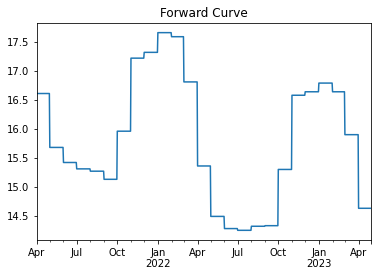

In [4]:
monthly_index = pd.period_range(start='2021-04-25', periods=25, freq='M')
monthly_fwd_prices = [16.61, 15.68, 15.42, 15.31, 15.27, 15.13, 15.96, 17.22, 17.32, 17.66, 
                      17.59, 16.81, 15.36, 14.49, 14.28, 14.25, 14.32, 14.33, 15.30, 16.58, 
                      16.64, 16.79, 16.64, 15.90, 14.63]
fwd_curve = pd.Series(data=monthly_fwd_prices, index=monthly_index).resample('D').fillna('pad')
%matplotlib inline
fwd_curve.plot(title='Forward Curve')

#### Interest Rates Curve
Act/365 continuously compounded interest rates should be specified as a Pandas Series instance with daily granularity. In these examples, for simplicity a linearly interpolated rates curve is used. 

<AxesSubplot:title={'center':'Interest Rate Curve'}>

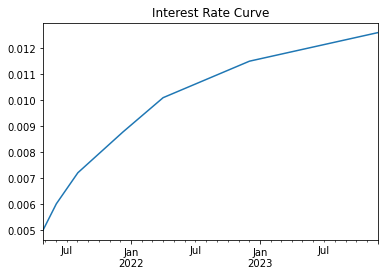

In [5]:
rates = [0.005, 0.006, 0.0072, 0.0087, 0.0101, 0.0115, 0.0126]
rates_pillars = pd.PeriodIndex(freq='D', data=['2021-04-25', '2021-06-01', '2021-08-01', '2021-12-01', '2022-04-01', 
                                              '2022-12-01', '2023-12-01'])
ir_curve = pd.Series(data=rates, index=rates_pillars).resample('D').asfreq('D').interpolate(method='linear')
ir_curve.plot(title='Interest Rate Curve')

#### Settlement Rule
This is a mapping from delivery period to the date on which cash settlement occurs. In a real-world usage scenario this would depend on the settlement rules for the forward market used to trade around the storage. This is specified as a function mapping from a pandas.Period instance (which represents the commodity delivery period) to the date on which this commodity delivery would be cash settle. The return instance needs to be date-like.

In the example below this is expressed as a function which maps to the 20th day of the following month.

In [6]:
def settlement_rule(delivery_date):
    return delivery_date.asfreq('M').asfreq('D', 'end') + 20

#### Valuation Date, Inventory and Discount Deltas
* **val_date** is the current time period as of when the valuation is performed. In this example as string is used, but instances of date, datetime or pandas.Period are also admissible.
* **inventory** is the current volume of commodity held in storage.
* **discount_deltas** is a boolean flag indicating whether the deltas should be either:
    * True: discounted and as such maintain the definition of a sensitivity of the NPV to the forward price as a partial derivative.
    * False: in the case where the forward market is OTC and not margined, the undiscounted deltas calculated should be used as the negative of the forward hedge to maintain delta neutrality. This is because a single unit of non-marginned forward has a delta of one discounted.  

In [7]:
val_date = '2021-04-25'
inventory = 1500.0
discount_deltas = True

### Least Square Monte Carlo Common Inputs
The following are inputs to both the Three-Factor Seasonal model and the Multi-Factor model.

* **num_sims** is the number of Monte Carlo simulations (or paths) used for the valuation. The higher this integer is, the more accurate the valuation will be, but the longer it will take to calculate.
* **seed** is an optional integer argument which is used as the seed to the Mersenne Twister random number generator. With all other inputs being equal, repeated runs of the valuation with the same seed will create identical simulated spot price paths. If the seed is omitted, a random seed will be used, and hence different spot prices will be generated even if all of the other inputs are identical. Specifying a seed is advisable in production usage as you will to be able to reproduce a valuation at any other time.
* **fwd_sim_seed** is another optional integer argument used if you want to specify the seed for the second forward spot price simulation. If omitted, unlike for when the seed argument is omitted, the second spot price will not use a random seed, rather it will use a continuation of the stream of random numbers generated by the first spot simulations, used for regressions. 

In [8]:
num_sims = 500
seed = 12
fwd_sim_seed = 25

Both model functions include two other optional arguments which have quite a technical usage. As such, in most cases these should be omitted from the function calls, as they are in the example below, so that the default values are used.
* **num_inventory_grid_points**: during the backward induction, at each time step the inventory space is discretized into a grid. At these inventory points the Bellman Equation is used to calculate the optimal decisions. This argument determines the maximum number of points in this grid. The higher the integer specified, the more accurate the valuation will be, but the slower the calculation will run.
* **numerical_tolerance** is used as a tolerance at various points in the calculation to determine if two floating point numbers are considered equal.

***
## Three Factor Seasonal Model
This section gives an example of using the storage valuation model where the commodity price dynamics are assumed to follow a three-factor seasonal model. The stochastic price model is described in [this paper](https://github.com/cmdty/core/blob/master/docs/three_factor_seasonal_model/three_factor_seasonal_model.pdf), which is a special case of the more general [multi-factor model](https://github.com/cmdty/core/blob/master/docs/multifactor_price_process/multifactor_price_process.pdf). The three factor model is particularly suited power and natural gas which show seaonality in the volatility and correlation. TODO reference Kyos paper.

### Three Factor Seasonal Model Specific Inputs
The following inputs are specific to the three-factor seasonal model.

#### Three Factor Price Dynamics Parameters
There are four numeric arguments which determine the spot price dynamics. See the [the three-factor paper](https://github.com/cmdty/core/blob/master/docs/three_factor_seasonal_model/three_factor_seasonal_model.pdf) for a description and details of calibration.

In [9]:
spot_mean_reversion = 91.0
spot_vol = 0.85
long_term_vol = 0.30
seasonal_vol = 0.19

#### Three Factor Basis Functions
The basis functions form an integral part of the Least Squares Monte Carlo valuation technique. Each basis function represents a linear component of the parameterisation of the expected continuation value given the inventory after an inject/withdraw decision. See the [original paper](https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf) by Longstaff and Schwartz for further details of the significance of basis functions in the valuation of financial derivatives.

The **basis_funcs** argument should be assigned to a string representing the basis functions. The format of this string should be the individual basis function deliminted by the '+' character. Any whitespace does not change the semantics of the string. Each individual basis function can consist of the following components:
* **1** for the contstant term. This should always be included on it's own, without multiplication with any other factors.
* **s** for the spot price.
* **x_st** for the short-term factor, the Brownian motion $z_{spot}(t)$.
* **x_lt** for the long-term factor, the Brownian motion $z_{long}(t)$.
* **x_sw** for the seasonal Summer-Winter factor, the Brownian motion $z_{seas}(t)$.

These can be augmented with the following operators:
* **\*** to multiply components, e.g. 's * x_st' is the spot price multiplied by the short-term factor.
* **\*\*** to raise to the power of, e.g. 'x_sw ** 2' is the Summer-Winter factor raised to the power of 2.

The example below includes basis functions for the first two powers of all four stochastic components, the product of the spot price and the short-term factor, and the constant term.

In [10]:
three_factor_basis_functions = '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st'

#### Calling Three Factor Seasonal Model
The three factor seasonal model can be run using the function **three_factor_seasonal_value**. This returns an instance of **MultiFactorValuationResults**, which has a property for the NPV, as printed in the example below. See the section [Valuation Results](#Valuation-Results) for more details on other information included in the results.

In [11]:
three_factor_results = three_factor_seasonal_value(
    cmdty_storage = storage,
    val_date = val_date,
    inventory = inventory,
    fwd_curve = fwd_curve,
    interest_rates = ir_curve,
    settlement_rule = settlement_rule,
    discount_deltas=discount_deltas,
    num_sims = num_sims,
    seed = seed,
    fwd_sim_seed = fwd_sim_seed,
    spot_mean_reversion = spot_mean_reversion,
    spot_vol = spot_vol,
    long_term_vol = long_term_vol,
    seasonal_vol = seasonal_vol,
    basis_funcs = three_factor_basis_functions
)
'{0:,.0f}'.format(three_factor_results.npv)

'69,524'

***
## General Multi-Factor Model
This section gives an example of using the storage valuation model where the commodity price dynamics are assumed to follow the price dynamics described in [this paper](https://github.com/cmdty/core/blob/master/docs/multifactor_price_process/multifactor_price_process.pdf). This model of price dynamics can be seen as a general framework which can be used to construct more specific commodity models based to the characteristics of the commodity.

### Multi-Factor Model Specific Inputs
The following inputs are specific to the multi-factor model.


#### Multi Factor Price Dynamics Parameters
Multi-factor price dynamics parameters are demonstrated below using an example of a two-factor model with one long-term non-mean reverting factor, and one short-term factor. Such a model could be suitable to model commodities where there is no seasonality in volatility and there is strong correlation between different points on the forward curve, e.g. crude oil.

##### Factor Volatility Curves and Mean Reversions
The factors argument should be assigned to an iterable of tuples. The number of tuples equals the number of factors. Tuple $i$ should have two elements:

1. The $i^{th}$ factor mean reversion, i.e. $\alpha_i$ from the document, as a float
2. The $i^{th}$ factor volatility function, i.e. $\sigma_i(T)$, as a Pandas Series, with index of type PeriodIndex with frequency the same as that assigned to **freq** when creating the storage object.

The example code below creates the factors with constant factor volatilities.

In [12]:
# Parameters for a constant volatility 2-factor model
long_term_vol = 0.14
long_term_mean_reversion = 0.0
short_term_vol = 0.64
short_term_mean_reversion = 16.2

# Construct the factors argument of multi_factor_value function
factor_index = pd.period_range(start=val_date, end=storage.end, freq=storage.freq)
long_term_vol_curve = pd.Series(index=factor_index, dtype='float64')
long_term_vol_curve[:] = long_term_vol

short_term_vol_curve = pd.Series(index=factor_index, dtype='float64')
short_term_vol_curve[:] = short_term_vol

factors = [(short_term_mean_reversion, short_term_vol_curve),
          (long_term_mean_reversion, short_term_vol_curve)]

##### Factor Correlations
The correlation between the different driving Brownian motion factors is specified as a matrix where element $i, j$ corresponds to $\rho_{i, j}$, the correlation between factors $i$ and $j$. For an n-factor model this should be an n by n 2-dimensional numpy ndarray. In the example below `factor_corrs_matrix` is created for this purpose.

However, in certain cases the factor correlations can be of different types:
* For a one-factor model factors can be `None` as factor correlations are not relevant.
* For a two-factor model a scalar of float type can be used. In the example below `factor_corrs` could be used without having to create the numpy array.

In [13]:
factor_corrs = 0.64
factor_corrs_matrix = np.array([[1.0, factor_corrs], 
                                [factor_corrs, 1.0]])

##### Multi-Factor Basis Functions
The basis function string will be very similar to that described in [Three Factor Basis Functions](#Three-Factor-Basis-Functions) section above. The only difference is that instead of **x_st**, **x_lt** and **x_sw**, strings of the form **xi** should be used, where $i$ is the factor index, starting at 0 for the first factor. For example use **x0** for the first factor, **x1** for the second factor and so on. Hence **xi** should only be used with $i$ values from 0 to $n-1$ for an $n$-factor model.

In the example below `multi_factor_basis_funcs` is created to use the first two powers for all factors and the spot price, as well as all cross-products between factors and the spot price. Finally the constant term is included.

In [14]:
multi_factor_basis_funcs = '1 + x0 + x1 + s + x0**2 + x1**2 + s**2 + x0*x1 + x1*s + x0*s'

#### Calling the Multi Factor Model
The multi-factor model can be run using the function **multi_factor_value**. This returns an instance of **MultiFactorValuationResults**, which has a property for the NPV, as printed in the example below. See the section [Valuation Results](#Valuation-Results) for more details on other information included in the results.

In [15]:
multi_factor_results = multi_factor_value(
    cmdty_storage = storage,
    val_date = val_date,
    inventory = inventory,
    fwd_curve = fwd_curve,
    interest_rates = ir_curve,
    settlement_rule = settlement_rule,
    discount_deltas=discount_deltas,
    num_sims = num_sims,
    seed = seed,
    fwd_sim_seed = fwd_sim_seed,
    factors = factors,
    factor_corrs = factor_corrs_matrix,
    basis_funcs = multi_factor_basis_funcs
)
'{0:,.0f}'.format(multi_factor_results.npv)

'63,505'

***
## User Specified Price Simulations
Should users wish to use any other model for price dynamics, the **value_from_sims** function runs the same pricing algorithm, but with price simulation data provided as arguments. The parameters to **value_from_sims** are mostly the same as for the two other pricing functions, except the following four parameters which are used to specify the simulated data:
* **sim_spot_regress** is a pandas.DataFrame holding the spot price simulations used in the regression step to calculate the expected value polynomials. The index of this DataFrame should be a pandas.PeriodIndex with the same frequency as that used to create the CmdtyStorage instance. Indices should be provided for all future active periods of the storage. Each column of this DataFrame contains a single simulation path, so the number of columns will equal the number of simulations.
* **sim_spot_valuation** is a pandas.DataFrame holding the spot price simulations used in the valuation step of the LSMC algorithm. During this step optimal decisions are calculated going forward in time using the spot prices provided in this argument, and the polynomials calculated in the regression step. The structure of this DataFrame is identical to that of sim_spot_regress described above.
* **sim_factors_regress** is an optional iterable of pandas.DataFrame containing the (usually) Markovian factors driving the spot prices in sim_spot_regress. Whether this argument is provided depends on whether the factors are present in the basis_funcs argument. For a single factor model it will not generally be necessary for the factor to be included in the regression, hence this argument can be omitted. However, it is typical (and closer to optimal) for a multi-factor model that the factors should be included in basis_funcs, hence sim_factors_regress should be provided by the caller. Each element of this iterable should contain the simulation data for each factor, hence len(sim_factors_regress) will equal the number of factors. Each DataFrame element of this will have the same structure as described for sim_spot_regress, with storage periods as the index and columns containing the simulation paths.
* **sim_factors_valuation** is an optional iterable of pandas.DataFrame and is the equivalent of sim_factor_regress, except it contains the factors driving sim_spot_valuation. The structure of the data should be identical to that of sim_factors_regress, with the number of elements equal to the number of factors.

#### Calling the Model With Externally Provided Simulations
Below is an example of calling **value_from_sims** with a 2-factor model which has been contrived for just the purpose of a simple demonstration.

In [ ]:
# 2-Factor model parameters
lt_vol_2f = 0.2
st_vol_2f = 0.6
mr_2f = 0.3

start_sim = pd.Period(val_date, freq='D')+1
sim_periods = pd.period_range(start=start_sim, end=storage.end)
num_sim_periods = len(sim_periods)

sqrt_dt = np.sqrt(1/365.0)
lt_step_stan_dev = lt_vol_2f * sqrt_dt
def generate_2f_sims():
    norms_factor_1 = np.random.normal(loc=0.0, scale=lt_step_stan_dev, size=(num_sim_periods, num_sims))
    factor_1_sims_array = np.cumsum(norms_factor_1, axis=0)
    factor_1_sims_data_frame = pd.DataFrame(data=factor_1_sims_array, index=sim_periods)
    st_step_stan_dev = st_vol_2f * sqrt_dt
    norms_factor_2 = np.random.normal(loc=0.0, scale=st_step_stan_dev, size=(num_sim_periods, num_sims))
    factor_2_sims_array = np.zeros(shape=(num_sim_periods, num_sims))
    factor_2_sims_array[0] = norms_factor_2[0]
    for i in range(1, num_sim_periods):
        factor_2_sims_array[i] = factor_2_sims_array[i-1]*(1.0 - mr_2f) + norms_factor_2[i]
    factor_2_sims_data_frame = pd.DataFrame(data=factor_2_sims_array, index=sim_periods)
    # No drift adjustment despite exponential, so not fitted to curve, and of no use in practice
    sims_spot_prices_data = np.matmul(np.diag(fwd_curve[sim_periods].values), np.exp(factor_1_sims_array + factor_2_sims_array))
    sims_spot_prices_data_frame = pd.DataFrame(data=sims_spot_prices_data, index=sim_periods)
    return sims_spot_prices_data_frame, (factor_1_sims_data_frame, factor_2_sims_data_frame)

sim_spot_regress, sim_factors_regress = generate_2f_sims()
sim_spot_valuation, sim_factors_valuation = generate_2f_sims()
two_factor_basis_funcs = '1 + x0 + x1 + s + x0**2 + x1**2 + s**2 + x0*x1 + x1*s + x0*s'

value_from_sims_results = value_from_sims(
    cmdty_storage = storage,
    val_date = val_date,
    inventory = inventory,
    fwd_curve = fwd_curve,
    interest_rates = ir_curve,
    settlement_rule = settlement_rule,
    discount_deltas=discount_deltas,
    sim_spot_regress = sim_spot_regress,
    sim_factors_regress = sim_factors_regress,
    sim_spot_valuation = sim_spot_valuation,
    sim_factors_valuation = sim_factors_valuation,
    basis_funcs = two_factor_basis_funcs
)
'{0:,.0f}'.format(value_from_sims_results.npv)

***
## Valuation Results
The functions **three_factor_seasonal_value**, **multi_factor_value** and **value_from_sims** all return instances of **MultiFactorValuationResults**. This class derives from NamedTuple and has many properties for the results of the optimisation, plus other calculation metadata. The subsections below describe these properties.

### NPV Properties
The the following attributes give information on the NPV (Net Present Value):
* **npv** is the full NPV including the option value.
* **intrinsic_npv** is the NPV calculated using a static optimisation assuming prices are deterministic, i.e. giving the storage no option value.
* **extrinsic_npv** is the value of just the optionality, i.e. npv minus intrinsic_npv.

In [ ]:
print('Full NPV:\t{0:,.0f}'.format(three_factor_results.npv))
print('Intrinsic NPV: \t{0:,.0f}'.format(three_factor_results.intrinsic_npv))
print('Extrinsic NPV: \t{0:,.0f}'.format(three_factor_results.extrinsic_npv))

### Deltas
The **deltas** property is of type pandas.Series and contains the senstivity of the full NPV to the forward price, for each future delivery period. This is calculated using pathwise differentiation as part of the Monte Carlo simulation, hence if not many simulation paths are used, as in this example, it can look quite jagged. With a higher number of simulations this will be smoother.

In [ ]:
three_factor_results.deltas.plot(title='Deltas')

### Intrinsic Profile
The **intrinsic_profile** property is of type pandas.DataFrame and contains information for each future time period on the optimisation performed for the intrinsic valuation. 

In [ ]:
three_factor_results.intrinsic_profile

### Trigger Prices
The **trigger_prices** property contains information on "trigger prices" which are approximate spot price levels at which the exercise decision changes.
* The withdraw trigger price is the spot price level, at time of nomination, above which the optimal decision will change to withdraw.
* The inject trigger price is the spot price level, at time of nomination, below which the optimal decision will change to inject.

The columns 'withdraw_volume' and 'inject_volume' contain the volumes withdrawn or injected at the trigger prices respectively. Note that these volumes could have lower absolute value to the storage maximum withdrawal and injection rates, because inventory constraints might mean that these decision volumes aren't achievable.

In [ ]:
display(three_factor_results.trigger_prices[0:10])

ax = three_factor_results.trigger_prices['inject_trigger_price'].plot(
    title='Trigger Prices Versus Forward Curve', legend=True)
three_factor_results.trigger_prices['withdraw_trigger_price'].plot(legend=True)
fwd_curve['2021-04-25' : '2022-04-01'].plot(legend=True)
ax.legend(['Inject Trigger Price', 'Withdraw Trigger', 'Forward Curve'])


### Simulated Values
**MultiFactorValuationResults** has a number of properties of type pandas.DataFrame which contain information at the individual simulation level from the internals of the Least Squares Monte Carlo valuation. Each of these DataFrame instances will have index (row label) of type PeriodIndex with frequency corresponding to the frequency string **freq** argument used to create the CmdtyStorage instance. These correspond to the periods for which the storage is active. The column labels will be integers corresponding to the Monte Carlo simulation number, hence will be in the range from 0 (inclusive) to num_sims (exclusive). The following is a list of such properties:

* **sim_spot_regress** is the first set of simulated spot prices are used to calculate the exercise continuation values via regression during a backward induction.
* **sim_spot_valuation** is the second set of simulated spot prices for which exercise (inject/withdraw) decisions are simulated going forward in time using the regression derived continuation values. The final NPV is calulated using the cash flow derived from these exercise decisions.
* **sim_factors_regress** is the simulated Markovian factors which are driving sim_spot_regress.
* **sim_factors_valuation** is the simulated Markovian factors which are driving sim_spot_valuation.
* **sim_inject_withdraw** contains the simulation optimal inject or withdraw volumes.
* **sim_inventory** contains the simulation inventory. For each simulation and time period this will be the cummulative sum of the starting inventory and the inject/withdraw volumes up until the time period.
* **sim_cmdty_consumed** contains the simulation commodity consumed upon injection/withdrawal as described in [this section](creating_storage_instances.ipynb#commodity_consumed) of the creating_storage_instances notebook.
* **sim_inventory_loss** contains the simulated inventory loss, as described [here](creating_storage_instances.ipynb#inventory_cost_loss).
* **sim_net_volume** contains the simulated net volume which will need to be in place at nomination time due to injection/withdrawal. This equals minus sim_inject_withdraw (because withdrawals are represented by negative numbers) minus sim_cmdty_consumed.
* **sim_pv** contains the simulated PV at each time period. This equals the discounted sum of:
    * Cash flow generated by purchasing or selling commodity on the spot market to inject or withdraw respectively, which is minus the corresponding volume in sim_inject_withdraw multiplied by the simulated spot price from sim_spot_valuation.
    * Minus the inject/withdraw cost.
    * Minus the corresponding value in sim_cmdty_consumed multiplied by the simulated spot price from sim_spot_valuation. This is the cost of commodity consumed upon injection/withdrawal.
    * Minus the inventory cost.

The following example shows usage of the sim_spot_valuation property to chart the mean, 10th and 90th percentile of simulated spot prices against the initial forward curve.

In [ ]:
sim_spot_valuation_mean = three_factor_results.sim_spot_valuation.aggregate(func='mean', axis='columns')
sim_spot_valuation_90th = three_factor_results.sim_spot_valuation.aggregate(func=np.percentile, q=90, axis='columns')
sim_spot_valuation_10h = three_factor_results.sim_spot_valuation.aggregate(func=np.percentile, q=10, axis='columns')

sim_spot_valuation_mean.plot(title = 'Statistics of Simulated Spot Prices', legend=True)
fwd_curve['2021-04-25' : '2022-04-01'].plot(legend=True)
sim_spot_valuation_10h.plot(legend=True)
ax = sim_spot_valuation_90th.plot(legend=True)
ax.legend(['Mean', 'Forward Curve', '10th Percentile', '90th Percentile'])

The properties **sim_factors_regress** and **sim_factors_valuation** are both tuples of pandas DataFrames, with the position in the tuple representing the factor number. The structure of the DataFrames is the same as for the spot simulation properties, with a row index representing the spot period simulated, and the column index representing the simulation number. The code below picks out simulation 125 and plots the simulated paths of the three factors. It also shows the order of the 3 different factor in the 3-factor cases.

In [ ]:
sim_number=125
st_factor = three_factor_results.sim_factors_regress[0][sim_number]
lt_factor = three_factor_results.sim_factors_regress[1][sim_number]
seas_factor = three_factor_results.sim_factors_regress[2][sim_number]

st_factor.plot(title = 'Simulation of 3 Factors', legend=True)
lt_factor.plot(legend=True)
ax_factors = seas_factor.plot(legend=True)

ax_factors.legend(['Short-Term Factor', 'Long-Term Factor', 'Seasonal Factor'])

### Expected Profile
The **expected_profile** property is a Pandas DataFrame containing the expected value of several quantities simulated during the valuation.

In [ ]:
three_factor_results.expected_profile

***
## Instrumentation
There are two ways to instrument the valuation code: an on-progress call-back and logging. This section describes both of these.

### Progress Callback
Both valuation functions have an optional argument **on_progress_update** which should be assigned to a callable (i.e. a function) which accepts one argument and has void return. When running the valuation the callable will be invoked with a float instance passed in to the single argument with a numeric approximation of the percentage progress of the total calculation. A typical usage scenario would be to wire this up to a progress bar. This is particularly important from a usability perspective, when a high number of Monte-Carlo simulations are used, hence the calculations can take a long time.

The example below demonstrates this with a IPython progress bar widget.

In [ ]:
progress_wgt = ipw.FloatProgress(min=0.0, max=1.0)

def on_progress(progress):
    progress_wgt.value = progress

def btn_value_progress_clicked(b):
    on_progress_demo_results = three_factor_seasonal_value(
        cmdty_storage = storage,
        val_date = '2021-04-25',
        inventory = 1500.0,
        fwd_curve = fwd_curve,
        interest_rates = ir_curve,
        settlement_rule = lambda decision_date: decision_date.asfreq('M').asfreq('D', 'end') + 20,
        spot_mean_reversion = 45.0,
        spot_vol = 0.65,
        long_term_vol = 0.21,
        seasonal_vol = 0.18,
        num_sims = 500,
        basis_funcs = '1 + x_st + x_sw + x_lt + x_st**2 + x_sw**2 + x_lt**2 + x_st**3 + x_sw**3 + x_lt**3',
        discount_deltas=True,
        on_progress_update = on_progress
    )
    
btn_calc_value_progress = ipw.Button(description='Calc Storage Value')
btn_calc_value_progress.on_click(btn_value_progress_clicked)
display(btn_calc_value_progress)
display(progress_wgt)

### Logging
The cmdty_storage package makes use of the [standard Python logging module](https://docs.python.org/3/library/logging.html) by exposing a logger object at the level of the cmdty_storage package, which is instantiated with the name 'cmdty.storage'. A log handler can be added to this in order to direct the logged information to the desired destination. See the [logging advanced tutorial](https://docs.python.org/3/howto/logging.html#logging-advanced-tutorial) for more information on using appenders.

The following uses slightly modified code from an example in the ipywideget [documentation](https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html#Integrating-output-widgets-with-the-logging-module) to create a custom logging handler which prints to an [Output widget](https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html).

In [ ]:
import cmdty_storage
import logging

class OutputWidgetHandler(logging.Handler):
    """ Custom logging handler sending logs to an output widget """

    def __init__(self, *args, **kwargs):
        super(OutputWidgetHandler, self).__init__(*args, **kwargs)
        layout = {
            'width': '100%',
            'height': '160px',
            'border': '1px solid black',
            'overflow_y': 'auto',
        }
        self.out = ipw.Output(layout=layout)

    def emit(self, record):
        """ Overload of logging.Handler method """
        formatted_record = self.format(record)
        new_output = {
            'name': 'stdout',
            'output_type': 'stream',
            'text': formatted_record+'\n'
        }
        self.out.outputs = self.out.outputs + (new_output, )

    def show_logs(self):
        """ Show the logs """
        display(self.out)

    def clear_logs(self):
        """ Clear the current logs """
        self.out.clear_output()

handler = OutputWidgetHandler()
handler.setFormatter(logging.Formatter('%(asctime)s  - [%(levelname)s] %(message)s'))

cmdty_storage.logger.setLevel(logging.INFO)

def btn_value_logging_clicked(b):
    cmdty_storage.logger.addHandler(handler)
    logging_demo_results = three_factor_seasonal_value(
        cmdty_storage = storage,
        val_date = '2021-04-25',
        inventory = 1500.0,
        fwd_curve = fwd_curve,
        interest_rates = ir_curve,
        settlement_rule = lambda decision_date: decision_date.asfreq('M').asfreq('D', 'end') + 20,
        spot_mean_reversion = 45.0,
        spot_vol = 0.65,
        long_term_vol = 0.21,
        seasonal_vol = 0.18,
        num_sims = 500,
        basis_funcs = '1 + x_st + x_sw + x_lt + x_st**2 + x_sw**2 + x_lt**2 + x_st**3 + x_sw**3 + x_lt**3',
        discount_deltas=True,
    )
    cmdty_storage.logger.removeHandler(handler)

def btn_on_clear_logs_clicked(b):
    handler.clear_logs()
    
btn_calc_value_logging = ipw.Button(description='Calc Storage Value')
btn_calc_value_logging.on_click(btn_value_logging_clicked)
display(btn_calc_value_logging)

btn_clear_logs = ipw.Button(description='Clear Logs')
btn_clear_logs.on_click(btn_on_clear_logs_clicked)
display(btn_clear_logs)

handler.show_logs()

***
## References
* Boogert, A. and de Jong, C. ().  Gas storage valuation using a multi-factor process. J.Energy Mark., 4:1–24, 12 2011. doi: 10.21314/JEM.2011.067.
* Fowler, J. C. (2020). *Multi-factor Commodity Price Process: Spot and Forward Price Simulation*. URL https://github.com/cmdty/core/blob/master/docs/multifactor_price_process/multifactor_price_process.pdf.
